<a href="https://colab.research.google.com/github/yhlyyuu/ML/blob/main/rockpaperscissors_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
# import libraries
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
from google.colab import files
from keras.preprocessing import image
import matplotlib.image as mpimg
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
# Check tensorflow version
print(tf.__version__)

2.18.0


# Import Dataset

In [ ]:
import tensorflow_datasets as tfds
# 1. 下載與載入資料集
(train_ds, test_ds), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

# Extract file

In [ ]:


IMG_SIZE = 150
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

def preprocess(image, label):
    # 確保 image 有 3 維 (H, W, C)
    if image.shape.rank == 2:
        image = tf.expand_dims(image, axis=-1)
    elif image.shape.rank == 3 and image.shape[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)

    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    image = data_augmentation(image)  # ✅ 放在 resize + cast 之後
    return image, label

BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)


# Convolution Neural Network

In [ ]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.GlobalAveragePooling2D(),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Tampilkan summary model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 327,747 (1.25 MB)

 Trainable params: 327,747 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Create Callbacks

In [ ]:


from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data = test_ds,
                    verbose = 1,
                    validation_steps=3,
                    callbacks=[reduce_lr, early_stop]
                    )

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - accuracy: 0.3237 - loss: 1.1031 - val_accuracy: 0.3229 - val_loss: 1.0819 - learning_rate: 0.0010
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.4127 - loss: 1.0656 - val_accuracy: 0.5833 - val_loss: 0.9197 - learning_rate: 0.0010
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.5398 - loss: 0.9157 - val_accuracy: 0.6458 - val_loss: 0.6971 - learning_rate: 0.0010
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.7048 - loss: 0.6599 - val_accuracy: 0.8750 - val_loss: 0.3748 - learning_rate: 0.0010
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 0.8071 - loss: 0.5054 - val_accuracy: 0.8542 - val_loss: 0.3859 - learning_rate: 0.0010
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 196ms/step - accuracy: 0.8396 - loss: 0.4028 - val_accuracy: 0.9375 - val_loss: 0.2191 - learning_rate: 0.0010
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.8937 - loss: 0.

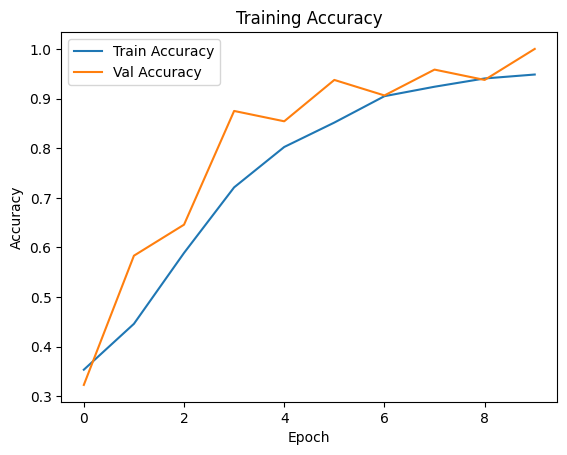

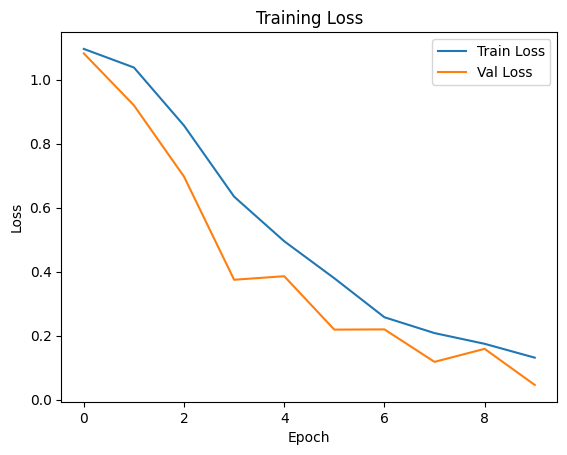

In [ ]:


# Accuracy 曲線
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

# Loss 曲線
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


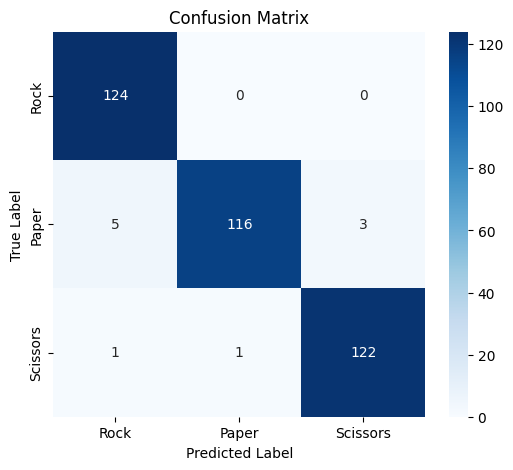

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 取得所有預測與真實標籤
y_true = []
y_pred = []

for images, labels in test_ds.unbatch():  # 移除 batch 維度
    img = tf.expand_dims(images, axis=0)  # 加 batch 維度
    pred = model.predict(img, verbose=0)
    pred_label = np.argmax(pred, axis=1)[0]
    y_pred.append(pred_label)
    y_true.append(labels.numpy())

# 計算混淆矩陣
cm = confusion_matrix(y_true, y_pred)
labels = ['Rock', 'Paper', 'Scissors']

# 畫出混淆矩陣
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=labels))


              precision    recall  f1-score   support

        Rock       0.95      1.00      0.98       124
       Paper       0.99      0.94      0.96       124
    Scissors       0.98      0.98      0.98       124

    accuracy                           0.97       372
   macro avg       0.97      0.97      0.97       372
weighted avg       0.97      0.97      0.97       372



# Model Evaluate

In [ ]:
# Evaluasi model pada training data
print("Evaluasi train data")
results = model.evaluate(train_generator, batch_size=32)
print('Loss: {:.4f}'.format(results[0]))
print('Accuracy: {:.2f}%'.format(results[1]*100))

In [ ]:
# Evaluasi model pada validation data
print("Evaluasi validation data")
results = model.evaluate(validation_generator, batch_size=32)
print('Loss: {:.4f}'.format(results[0]))
print('Accuracy: {:.2f}%'.format(results[1]*100))

# Plotting Loss and Accuracy

In [ ]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12,4)

# Define accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Define loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plotting accuracy
ax[0].plot(epochs, acc, 'r', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='upper left')

# Plotting loss
ax[1].plot(epochs, loss, 'r', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper left')

plt.show()

# Model Prediction

In [ ]:
def predict_image(image_upload, model = model):
  im = image_upload
  im_array = np.asarray(im)
  im_array = im_array*(1/225)
  im_input = tf.reshape(im_array, shape = [1, 150, 150, 3])

  predict_array = model.predict(im_input)[0]

  import pandas as pd
  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  prod = ['Paper', 'Rock', 'Scissors']
  df['Product'] = prod
  df = df[['Product', 'Probability']]

  predict_label = np.argmax(model.predict(im_input))

  if predict_label == 0:
      predict_product = 'Paper'
  elif predict_label == 1:
      predict_product = 'Rock'
  else:
      predict_product = 'Scissor'

  return predict_product, df

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

label, df = predict_image(img)

print('\n')
plt.show()
print("\nThe image is detected as " + label)
print('\n')
print(df)
print('\n')